In [1]:
#!/usr/bin/env python3

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

image_size = (128, 128)
batch_size = 16


img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)
num_classes = 1
latent_dim = 128

# Generator

noise = keras.layers.Input(shape=(latent_dim,))
generator_hidden = keras.layers.Dense(128 * 32 * 32, activation='gelu')(noise)
generator_hidden = keras.layers.Reshape((32, 32, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2,
                                                activation='gelu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2,
                                                activation='gelu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2DTranspose(channels, kernel_size=3,
                                       padding='same', activation='tanh')(generator_hidden)
generator = keras.Model(noise, g_image)
generator.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(0.0001,0.9))

# Discriminator

d_image = keras.layers.Input(shape=img_shape)
discriminator_hidden = keras.layers.Conv2D(16, kernel_size=3, strides=2,
                                           padding='same')(d_image)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(32, kernel_size=3, strides=2,
                                           padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(64, kernel_size=3, strides=2,
                                           padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(128, kernel_size=3, strides=1,
                                           padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Flatten()(discriminator_hidden)

valid = keras.layers.Dense(1, activation='sigmoid')(discriminator_hidden)
discriminator = keras.Model(d_image, valid)
discriminator.compile(loss=[keras.losses.BinaryCrossentropy(),
                            keras.losses.SparseCategoricalCrossentropy()],
                      optimizer=keras.optimizers.Adam(0.00002,0.5),
                      metrics=['accuracy'])

# Combined model

discriminator.trainable = False
valid = discriminator(g_image)
combined = keras.Model(noise,valid)
combined.compile(loss=[keras.losses.BinaryCrossentropy(),
                       keras.losses.SparseCategoricalCrossentropy()],
                 optimizer=keras.optimizers.Adam(0.0002,0.5))


2022-11-22 09:04:58.581583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 09:04:58.581615: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 09:04:58.581649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-ndh4b): /proc/driver/nvidia/version does not exist
2022-11-22 09:04:58.581845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
generator.load_weights("michelangelo_gan_weights.h5")

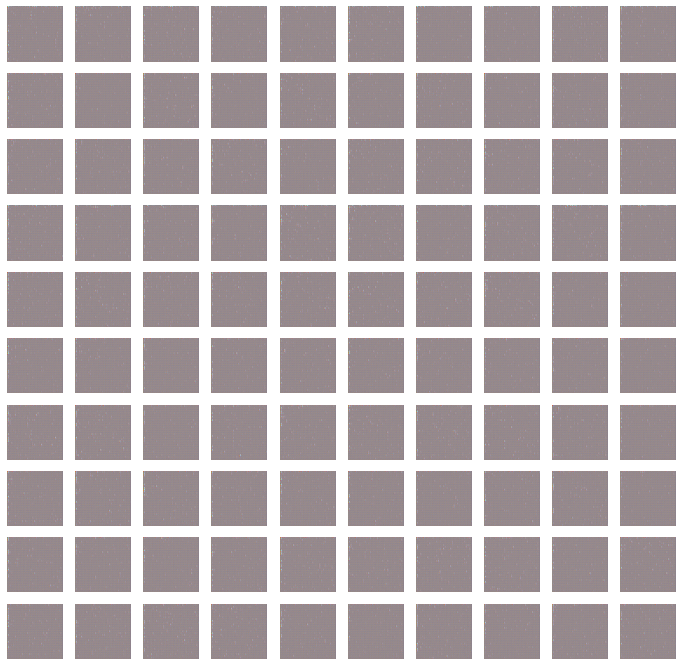

In [14]:
## Testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))

# Make some fakes!
generated_images = generator.predict(noise)
# Rescale images 0 - 1
generated_images = 0.5 * (generated_images + 1)

# Plot them...
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,:])
        axs[i,j].axis('off')
        count += 1
plt.show()